## Regression and predictive modeling of Rossmann stores daily sales

**1. Prepare Problem**

In [1]:
# a) Load libraries

import os

import pandas as pd
from pandas import set_option
from pandas import DataFrame

import numpy as np

import xgboost as xgb

import matplotlib.pyplot as plt
import seaborn as sn

from tensorflow import keras

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from pickle import dump

D:\Software\Anaconda\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
# b) Load dataset
# Get all the files in the working directory
cwd = os.getcwd()
files = os.listdir(cwd)
print("List files in %r: %s" % (cwd, files))

# Load and view each file in the dataset
raw_train = pd.read_csv('train.csv', header=0)
print(raw_train.shape)
print(raw_train.head(10))
print(raw_train.dtypes)

raw_test = pd.read_csv('test.csv', header=0)
print(raw_test.shape)
print(raw_test.head(10))
print(raw_test.dtypes)

store = pd.read_csv('store.csv', header=0)
print(store.shape)
print(store.head(10))
print(store.dtypes)

List files in 'D:\\PROJECTS\\GitHub_Projects\\3_Regression_rossman_store_sales': ['.ipynb_checkpoints', 'finalized_model.sav', 'Regression_Rossmann_store_sales_final.ipynb', 'Regression_Rossmann_store_sales_V0.ipynb', 'Rossmann_store_sales_NN.py', 'Rossmann_store_sales_NN_23Nov.py', 'Rossmann_store_sales_NN_25Nov.py', 'Rossmann_store_sales_NN_30Nov.py', 'Rossmann_store_sales_NN_OK.py', 'Rossmann_store_sales_NN_V1.py', 'sample_submission.csv', 'store.csv', 'test.csv', 'train.csv', 'Untitled.ipynb']
(1017209, 9)
   Store  DayOfWeek        Date  Sales  Customers  Open  Promo StateHoliday  \
0      1          5  2015-07-31   5263        555     1      1            0   
1      2          5  2015-07-31   6064        625     1      1            0   
2      3          5  2015-07-31   8314        821     1      1            0   
3      4          5  2015-07-31  13995       1498     1      1            0   
4      5          5  2015-07-31   4822        559     1      1            0   
5      6  

C:\Users\huyha\AppData\Local\Temp\ipykernel_6612\738645405.py:8: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  raw_train = pd.read_csv('train.csv', header=0)


The test set doesn't have Sales and Customers features so we can't use them for validation purposes. The file Store.csv includes useful data that can aid the training process so we merge it with Train.csv data on the same column named "Store".

In [3]:
# Merge the store data to train dataset
data = raw_train.merge(store,on=["Store"], how="inner")
print(data.shape)
print(data.dtypes)

(1017209, 18)
Store                          int64
DayOfWeek                      int64
Date                          object
Sales                          int64
Customers                      int64
Open                           int64
Promo                          int64
StateHoliday                  object
SchoolHoliday                  int64
StoreType                     object
Assortment                    object
CompetitionDistance          float64
CompetitionOpenSinceMonth    float64
CompetitionOpenSinceYear     float64
Promo2                         int64
Promo2SinceWeek              float64
Promo2SinceYear              float64
PromoInterval                 object
dtype: object


**2. Dataset summary**

In [4]:
# a) Descriptive statistics
set_option("display.precision", 3)
print(data.describe())

           Store  DayOfWeek      Sales  Customers       Open      Promo  \
count  1.017e+06  1.017e+06  1.017e+06  1.017e+06  1.017e+06  1.017e+06   
mean   5.584e+02  3.998e+00  5.774e+03  6.331e+02  8.301e-01  3.815e-01   
std    3.219e+02  1.997e+00  3.850e+03  4.644e+02  3.755e-01  4.858e-01   
min    1.000e+00  1.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00   
25%    2.800e+02  2.000e+00  3.727e+03  4.050e+02  1.000e+00  0.000e+00   
50%    5.580e+02  4.000e+00  5.744e+03  6.090e+02  1.000e+00  0.000e+00   
75%    8.380e+02  6.000e+00  7.856e+03  8.370e+02  1.000e+00  1.000e+00   
max    1.115e+03  7.000e+00  4.155e+04  7.388e+03  1.000e+00  1.000e+00   

       SchoolHoliday  CompetitionDistance  CompetitionOpenSinceMonth  \
count      1.017e+06            1.015e+06                 693861.000   
mean       1.786e-01            5.430e+03                      7.223   
std        3.831e-01            7.715e+03                      3.212   
min        0.000e+00            2.00

In [5]:
# checking categorical features
cat_features = data.select_dtypes(include='O').keys()
# display variabels
cat_features

Index(['Date', 'StateHoliday', 'StoreType', 'Assortment', 'PromoInterval'], dtype='object')

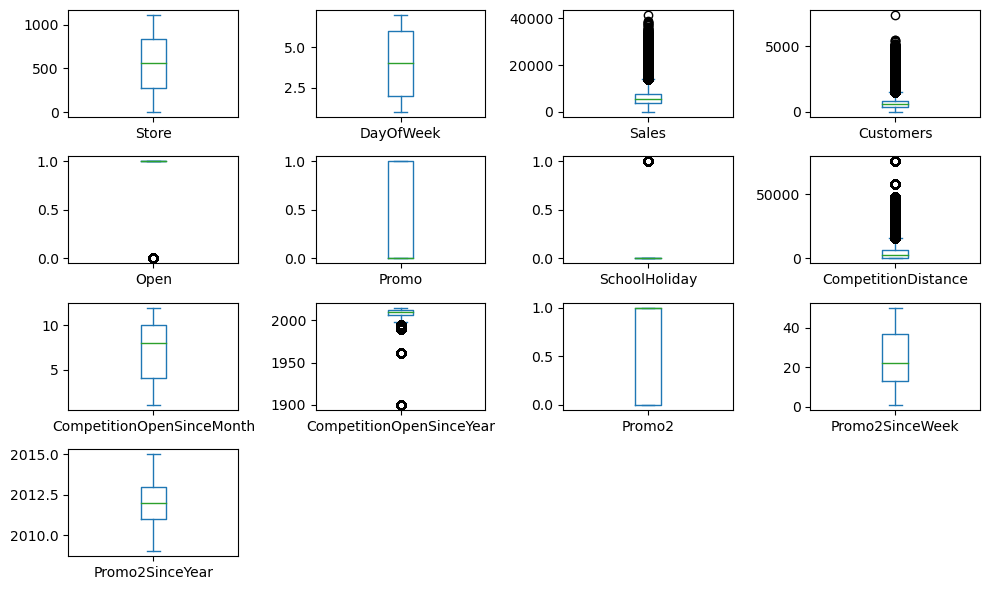

In [6]:
# b) Data visualizations
# Box and Whisker Plots of a few features

plt.rcParams["figure.figsize"] = [10, 6]
plt.rcParams["figure.autolayout"] = True

raw_plot = pd.DataFrame(data)
raw_plot.plot(kind='box', subplots=True, layout=(4,4), sharex=False, sharey=False)
plt.show()

We can see the data skewed to the low values in Sales, Customers, and CompetitionDistance

                               Store  DayOfWeek  Sales  Customers       Open  \
Store                      1.000e+00 -8.484e-06  0.005      0.024 -4.674e-05   
DayOfWeek                 -8.484e-06  1.000e+00 -0.462     -0.386 -5.290e-01   
Sales                      5.126e-03 -4.621e-01  1.000      0.895  6.785e-01   
Customers                  2.432e-02 -3.864e-01  0.895      1.000  6.168e-01   
Open                      -4.674e-05 -5.290e-01  0.678      0.617  1.000e+00   
Promo                      5.786e-05 -3.929e-01  0.452      0.316  2.950e-01   
SchoolHoliday              6.407e-04 -2.054e-01  0.085      0.072  8.617e-02   
CompetitionDistance       -2.641e-02 -2.461e-05 -0.019     -0.103  7.992e-03   
CompetitionOpenSinceMonth -5.075e-02  5.882e-06 -0.028     -0.031  1.384e-03   
CompetitionOpenSinceYear  -4.592e-03 -2.537e-05  0.013      0.009  2.771e-03   
Promo2                     8.488e-03  1.683e-04 -0.091     -0.150 -8.309e-03   
Promo2SinceWeek            9.865e-03  1.

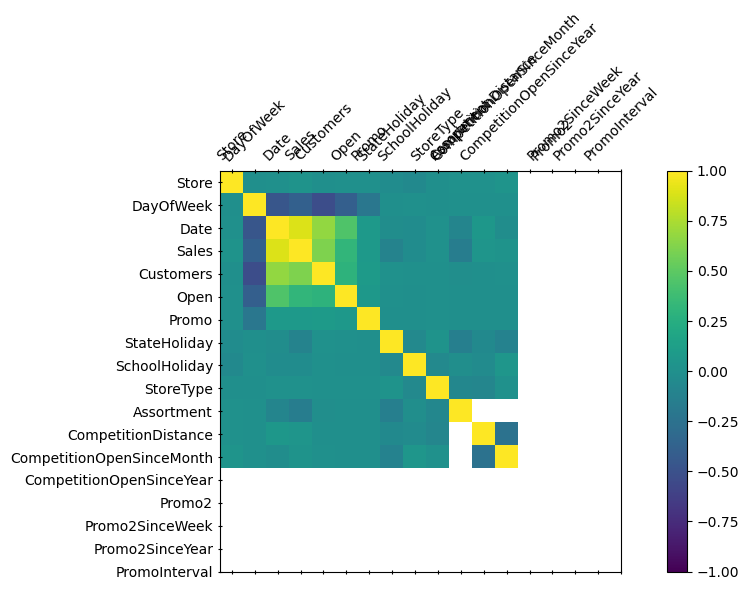

In [7]:
# correlation matrix between all pairs of attributes
print(data.corr(method='pearson'))
names = list(data)
fig = plt.figure()
sub_fig = fig.add_subplot(111)
cm = sub_fig.matshow(data.corr(), vmin=-1, vmax=1, interpolation='none')
fig.colorbar(cm)
sub_fig.tick_params(direction='inout')
sub_fig.set_xticks(np.arange(0,18))
sub_fig.set_yticks(np.arange(0,18))
sub_fig.set_xticklabels(names, rotation=45)
sub_fig.set_yticklabels(names)
plt.show()

The correlation matrix indicates sales data is sensitive to the Date and Customers features

**3. Prepare Data**

In [8]:
# a) Data Cleaning

# Extract year, month, week, day from the Date feature

data['Date'] = pd.to_datetime(data['Date'], infer_datetime_format=True)
data["Year"] = data["Date"].dt.year
data["Month"] = data["Date"].dt.month
data["Week"] = data["Date"].dt.week
data["Day"] = data["Date"].dt.day

# Create 2 new features representing weekend and promotion
data["weekend"] = np.where(data["DayOfWeek"].isin([6, 7]), "Weekend","Weekday")
data["promotion"] = np.where(data["Month"].isin([7, 8, 11, 12]), "Pro_Month", "Reg_Month")

y_temp = data['Sales']

C:\Users\huyha\AppData\Local\Temp\ipykernel_6612\2610558992.py:8: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  data["Week"] = data["Date"].dt.week


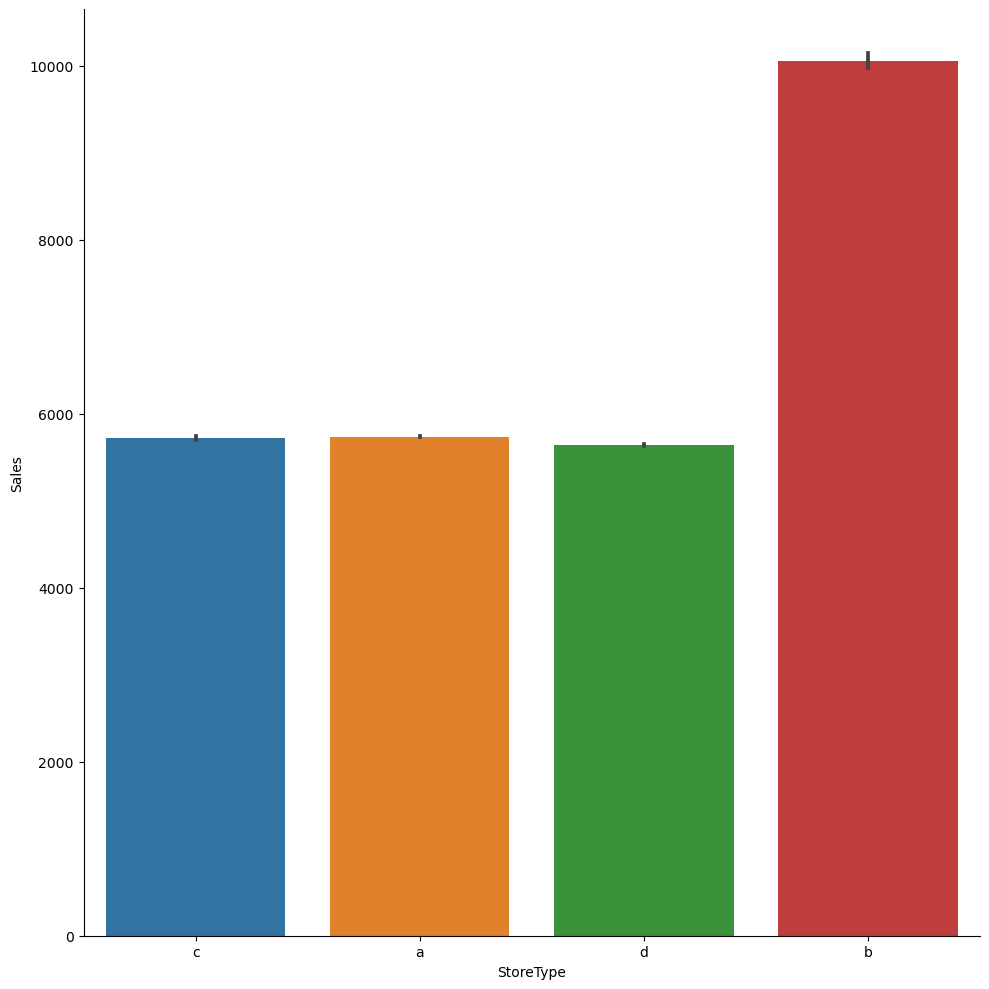

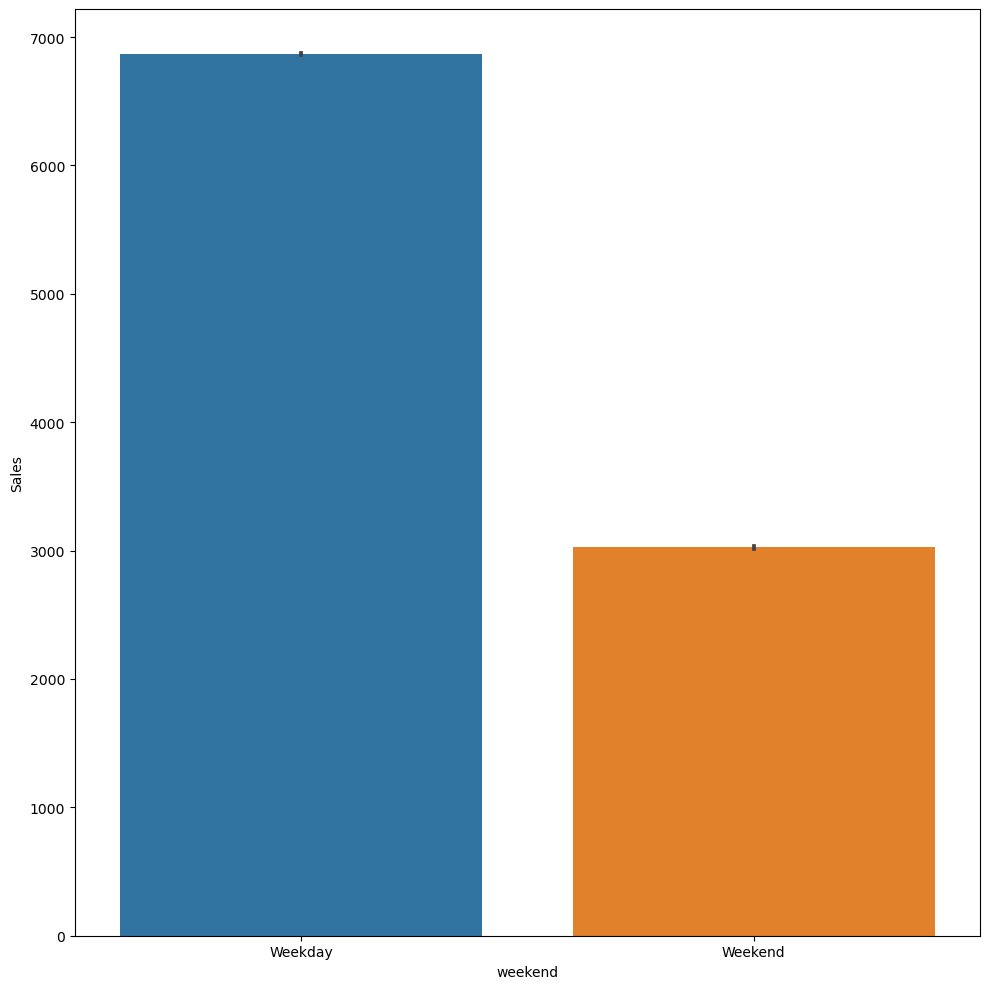

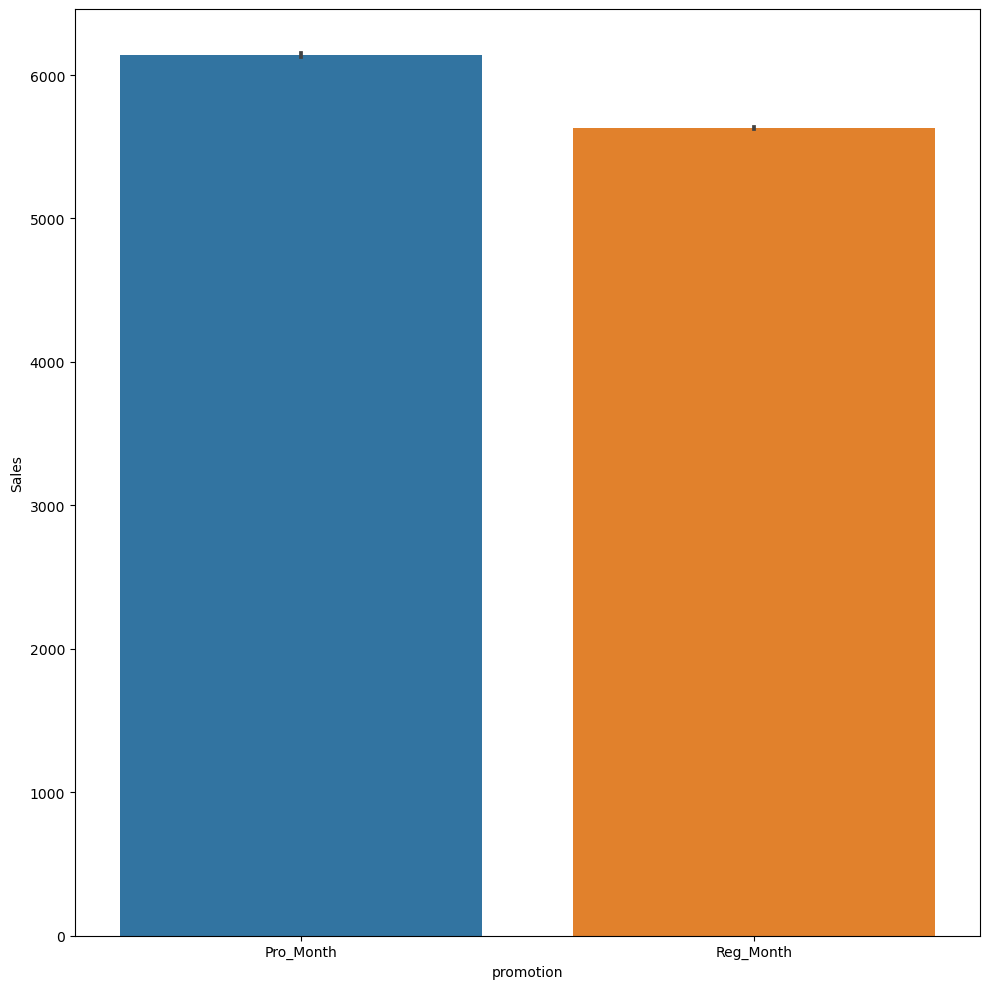

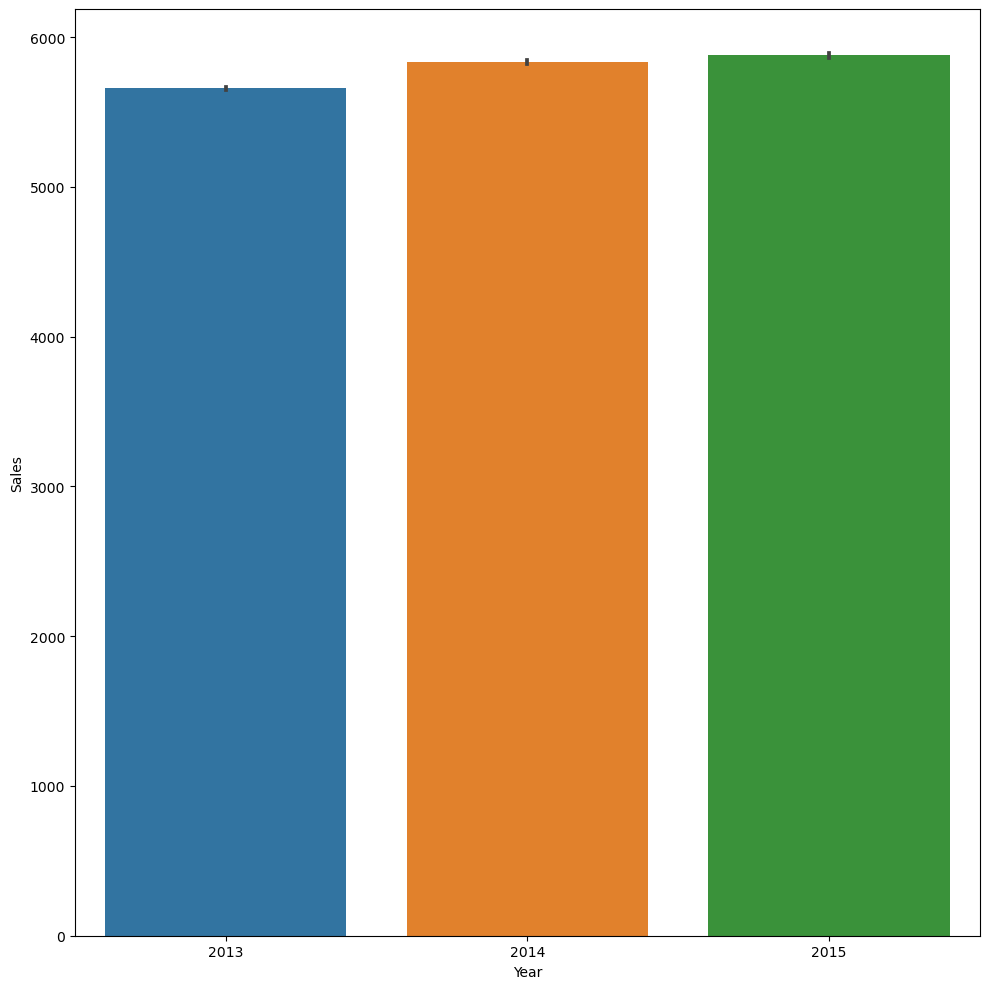

In [9]:
# Visualize Sales vs. store type 
fig1, ax1 = plt.subplots(figsize=(10, 10))
sn.barplot(x=data['StoreType'], y=y_temp, data=data, ax=ax1)

# Visualize Sales vs. weekend
fig2, ax2 = plt.subplots(figsize=(10, 10))
sn.barplot(x=data['weekend'], y=y_temp, data=data, ax=ax2)

# Visualize Sales vs. promotion months 
fig3, ax3 = plt.subplots(figsize=(10, 10))
sn.barplot(x=data['promotion'], y=y_temp, data=data, ax=ax3)

# Visualize Sales vs. promotion months 
fig4, ax4 = plt.subplots(figsize=(10, 10))
sn.barplot(x=data['Year'], y=y_temp, data=data, ax=ax4)

sn.despine(fig1, fig2, fig3, fig4)

An interesting observation from the Sales vs Weekend chart is that sales on weekdays are generally higher than on weekends (Saturday and Sunday).

It is necessary to eliminate outliers in numerical data columns to improve the accuracy of training and validation processes. This can be done by determining the correlation between these columns and the target variable, identifying columns with low correlation, and then filtering out values that fall outside of the lower and upper bounds.

In [10]:
# calculate the correlation between numerical columns and target variable
corr_matrix = data.select_dtypes(include=np.number).corrwith(data['Sales']).sort_values(ascending=False)

# filter columns with low correlation 
corr_threshold = 0.05
low_corr_columns = corr_matrix[corr_matrix.abs() < corr_threshold].index

# remove outliers from numerical columns with low correlation
for column in low_corr_columns:
    lower = data[column].quantile(0.01)
    upper = data[column].quantile(0.99)
    data[column] = data[column].clip(lower, upper)

In [11]:
# summarize the number of unique values in each column
print(data.nunique())

# Identify columns with missing values and count the number of missing values
data.columns[data.isnull().any()]
print(data.isnull().sum())

Store                         1094
DayOfWeek                        7
Date                           942
Sales                        21734
Customers                     4086
Open                             2
Promo                            2
StateHoliday                     5
SchoolHoliday                    2
StoreType                        4
Assortment                       3
CompetitionDistance            641
CompetitionOpenSinceMonth       12
CompetitionOpenSinceYear        20
Promo2                           2
Promo2SinceWeek                 24
Promo2SinceYear                  7
PromoInterval                    3
Year                             3
Month                           12
Week                            52
Day                             31
weekend                          2
promotion                        2
dtype: int64
Store                             0
DayOfWeek                         0
Date                              0
Sales                             0
Cus

In [12]:
# Impute missing values with 'mode' values in this important variable (CompetitionDistance)
data["CompetitionDistance"]=data["CompetitionDistance"].fillna(data["CompetitionDistance"].mode()[0])

In [13]:
# Convert strings into categorial classes
mapping1 = {'a': 1, 'b': 2, 'c': 3, 'd': 4}
data['StoreType'] = data['StoreType'].replace(mapping1)

mapping2 = {'a': 1, 'b': 2, 'c': 3}
data['Assortment'] = data['Assortment'].replace(mapping2)

mapping3 = {'0': 0, 'a': 1, 'b': 2, 'c': 3}
data['StateHoliday'] = data['StateHoliday'].replace(mapping3)

# Convert strings into categorial classes
data = pd.get_dummies(data = data, columns = ["weekend", "promotion"])

In [14]:
# One hot encoding these categorial features
ohe = OneHotEncoder(categories='auto')
ohe.fit_transform(data[['StoreType', 'Assortment', 'StateHoliday']]).toarray()
print(data.shape)

(1017209, 26)


In [15]:
# b) Split-out validation dataset and drop unimportant columns

df = data.drop(columns=['Store', 'Date', 'CompetitionOpenSinceYear', 'CompetitionOpenSinceMonth', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval'], axis = 1)

X = df.drop(columns=['Sales'], axis = 1)
y = df['Sales']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [16]:
# c) Data Transforms
# Standardize the dataset by rescaling the distribution of values 

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

# convert the array back to a dataframe
X_train = DataFrame(X_train)
X_test = DataFrame(X_test)

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(762906, 18) (254303, 18)
(762906,) (254303,)


**4. Evaluate Algorithms**

In [17]:
# a) Spot check algorithms
# ML: Linear Regression
results = []
names = []

model_LR = LinearRegression()
model_LR.fit(X_train, y_train)
y_pred_LR = model_LR.predict(X_test)
LR = model_LR.score(X_test, y_test)
results.append(LR)
names.append('LR')

In [18]:
# Define baseline mean_absolute_error of y_test in the data set
y_mean = np.mean(y)
y_mean = np.array([y_mean]*len(y_test))
mae_ori = mean_absolute_error(y_test, y_mean)
print("Mean Absolute Error of original data: ", mae_ori)

# Calculate mean_absolute_error of the prediction
mae_pred_LR = mean_absolute_error(y_test, y_pred_LR)
print("Mean Absolute Error of predicted data: ", mae_pred_LR)

Mean Absolute Error of original data:  2887.0513217781754
Mean Absolute Error of predicted data:  1307.6651571052191


The prediction of the Linear Regression model seems to be within an acceptable range, as there is a low mean absolute error between the test data and the predicted data.

In [19]:
# Ensemble: Random Forest algorithm
model_RF = RandomForestRegressor(n_estimators=10)
model_RF.fit(X_train, y_train)
y_pred_RF = model_RF.predict(X_test)
RF = model_RF.score(X_test, y_test)
results.append(RF)
names.append('RF')

In [20]:
# Calculate mean_absolute_error of the prediction
mae_pred_RF = mean_absolute_error(y_test, y_pred_RF)
print("Mean Absolute Error of predicted data: ", mae_pred_RF)

Mean Absolute Error of predicted data:  1444.3143835044546


In [21]:
# XGBoost algorithm
# Use DMatrix to convert input data into internal data structure that is optimized for both memory efficiency and training speed.
df_xgb = xgb.DMatrix(data=X, label=y)
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, test_size=0.25)

model_xgb = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 1,
                max_depth = 5, alpha = 10, n_estimators = 10)

model_xgb.fit(X_train2,y_train2)

# Prediction
preds = model_xgb.predict(X_test2)
XGB = model_xgb.score(X_test2, y_test2)
results.append(XGB)
names.append('XGB')

D:\Software\Anaconda\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


In [22]:
# Compare algorithms
print(names, results)

['LR', 'RF', 'XGB'] [0.7615552919855225, 0.7546242490551249, 0.6510018888147739]


The Linear Regression surprisingly performs better than Random Forest and even XGBoost, one of the most powerful regression algorithm.

In [23]:
# b) Neural Network algorithms
# create keras Sequential model with 3 layers
NN_model = keras.Sequential([    
    keras.layers.Dense(300, input_shape = (18, ), activation = 'relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.4),
    keras.layers.Dense(150, activation = 'relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(1, activation='softplus')  
])

NN_model.compile(optimizer = 'adam',
                loss = 'mean_squared_logarithmic_error',
                metrics=['mse'])

Epoch 1/20
5961/5961 [==============================] - 47s 8ms/step - loss: 16.5189 - mse: 41393272.0000 - val_loss: 11.9416 - val_mse: 32098700.0000
Epoch 2/20
5961/5961 [==============================] - 44s 7ms/step - loss: 6.2722 - mse: 17271484.0000 - val_loss: 0.1444 - val_mse: 7790498.0000
Epoch 3/20
5961/5961 [==============================] - 43s 7ms/step - loss: 0.0509 - mse: 2711173.0000 - val_loss: 0.0684 - val_mse: 4003513.5000
Epoch 4/20
5961/5961 [==============================] - 43s 7ms/step - loss: 0.0426 - mse: 2066879.3750 - val_loss: 0.0581 - val_mse: 3396591.7500
Epoch 5/20
5961/5961 [==============================] - 43s 7ms/step - loss: 0.0408 - mse: 2004354.0000 - val_loss: 0.0631 - val_mse: 3461949.7500
Epoch 6/20
5961/5961 [==============================] - 47s 8ms/step - loss: 0.0419 - mse: 2005719.8750 - val_loss: 0.0702 - val_mse: 3822575.0000
Epoch 7/20
5961/5961 [==============================] - 41s 7ms/step - loss: 0.0399 - mse: 1911820.8750 - val_los

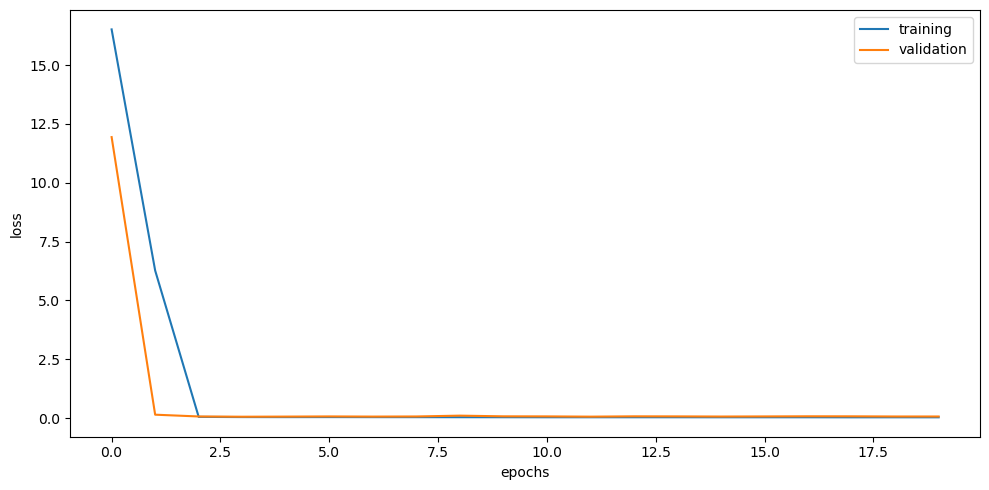

In [24]:
# fit the keras model on the dataset
model_fit = NN_model.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=20, batch_size=128)

# Plot learning curve
plt.figure(figsize = (10, 5))
plt.plot(model_fit.history['loss'], label = 'training')
plt.plot(model_fit.history['val_loss'], label = 'validation')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

The loss value of the training (0.03) and validation (0.06) are fairly low meaning fairly good prediction probability to the corresponding true value.  

**5. Finalize Model**

In [25]:
# a) Predictions on validation dataset
# Keras Sequential model estimate accuracy on validation dataset
y_pred_NN = NN_model.predict(X_test)

7947/7947 [==============================] - 18s 2ms/step


In a regression problem, it is common to use the mean error as a measure of validation. This is done by first calculating the mean absolute error (MAE) of the test data with the mean of dataset, and then calculating the MAE of the test data with the predicted data. The resulting mean absolute error indicates that the prediction performance of the Keras Sequential neural network is similar to that of the Linear Regression model.

In [26]:
# Calculate mean_absolute_error of the prediction
mae_pred_NN = mean_absolute_error(y_test, y_pred_NN)
print("Mean Absolute Error of predicted data: ", mae_pred_NN)

Mean Absolute Error of predicted data:  1360.4263878902957


In [27]:
# b) Save model for later use
# save the model to disk
filename = 'finalized_model.sav'
dump(NN_model, open(filename, 'wb'))

INFO:tensorflow:Assets written to: ram://28e63b2d-942d-45d1-9e6b-58ce4d84dddb/assets


**6. Conclusions**

- Staring with the problem statement, we performed exploratory data analysis and cleaning before passing the data into algorithms for training and prediction.

- Of the three ML algorithms, Linear Regression and XGBoost achieved better score than Random Forest (0.66 vs. 0.53).

- The performance of the neural network model (Keras Sequential) with 3 layers and dropput regulation seems to be comparable to the Linear Regression. Further tunning of the hyperparameter may yield a better prediction score.